In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import csv
import math
import cv2
from numpy.linalg import lstsq,solve
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from Utilities import PlotImages
from sklearn.linear_model import LogisticRegressionCV, RidgeCV
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from time import time
from tensorflow.keras.applications.vgg16 import VGG16
from Utilities import *

In [2]:
def LinearRegressor(w,X):
    yh = np.matmul(X, w)
    return yh

def MSE(y, yh):
    mse = ((y-yh)**2).mean()
    return mse

## 2

# save images and labels into blood_cell_train and blood_cell_test

In [3]:
# blood_cell_train

In [4]:
directory = './Data/dataset2-master/images/TRAIN/'

In [5]:
generator = ImageDataGenerator(rescale = 1/255)
image_generator = generator.flow_from_directory(directory,
                                               target_size=(32,32),
                                               batch_size =10000,
                                               class_mode='sparse')

Found 9957 images belonging to 4 classes.


In [6]:
images, labels = image_generator.next()

In [7]:
labels = labels.astype('int')
labels

array([2, 0, 1, ..., 1, 1, 3])

In [8]:
label_names = list(image_generator.class_indices)
label_names

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [9]:
np.savez('./Data/blood_cell_train', train_images = images, train_labels = labels, train_label_names= label_names)

In [10]:
# blood_cell_test
directory = './Data/dataset2-master/images/TEST/'
generator = ImageDataGenerator(rescale = 1/255)
image_generator = generator.flow_from_directory(directory,
                                               target_size=(32,32),
                                               batch_size =10000,
                                               class_mode='sparse')
images, labels = image_generator.next()

labels = labels.astype('int')

label_names = list(image_generator.class_indices)
np.savez('./Data/blood_cell_test', test_images = images, test_labels = labels, test_label_names= label_names)

Found 2487 images belonging to 4 classes.


# Baseline

## Linear Classifier

In [11]:
WBC = np.load('./Data/blood_cell_train.npz')

In [12]:
WBC.files

['train_images', 'train_labels', 'train_label_names']

In [13]:
labels = WBC['train_labels']
labels

array([2, 0, 1, ..., 1, 1, 3])

In [14]:
images = WBC['train_images']
images.shape

(9957, 32, 32, 3)

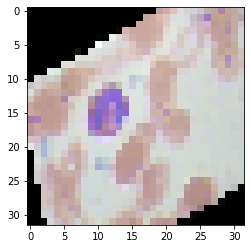

In [15]:
plt.imshow(images[1,:,:])

In [16]:
X = images.reshape(9957,32*32*3)
X.shape

(9957, 3072)

In [17]:
y = WBC['train_labels']
y

array([2, 0, 1, ..., 1, 1, 3])

In [18]:
# one-hot-encoding
Y = np.zeros((9957,10))
for i in range(9957):
    Y[i,y[i]] = 1

In [19]:
w = lstsq(X,Y,rcond=None)[0]
print(w.shape)
w

(3072, 10)


array([[-0.19986223, -0.03867375,  0.06577508, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.05901311, -0.00350394, -0.04976801, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09619761,  0.07967955, -0.01314885, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.34070127, -0.18110947,  0.06779543, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18316203,  0.28051252,  0.08144323, ...,  0.        ,
         0.        ,  0.        ],
       [-0.49462198, -0.15433471, -0.13844709, ...,  0.        ,
         0.        ,  0.        ]])

In [20]:
Yh = np.matmul(X,w)

In [21]:
yh = Yh.argmax(axis=1)
yh

array([2, 0, 1, ..., 1, 1, 3], dtype=int64)

In [22]:
y = Y.argmax(axis=1)
y

array([2, 0, 1, ..., 1, 1, 3], dtype=int64)

In [23]:
diff = (y!=yh).sum()
diff

2443

In [24]:
total = len(y)
total

9957

In [25]:
diff/total

0.2453550266144421

In [26]:
1-Y.mean(axis=0).max()

0.7490207893943959

The error rate of Linear Classifier,0.245 is much lower than the baseline error rate, 0.749.

In [27]:
# wrong labels
images1 = images[(y!=yh),:,:]
labels1= labels[(y!=yh)]
labels1_pred = yh[(y!=yh)]

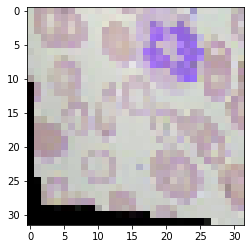

Actual label: NEUTROPHIL
Predicted label: MONOCYTE


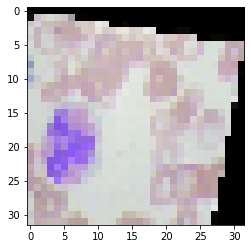

Actual label: NEUTROPHIL
Predicted label: LYMPHOCYTE


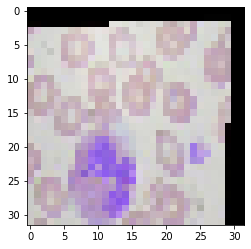

Actual label: NEUTROPHIL
Predicted label: MONOCYTE


In [28]:
for i in range(3):
    plt.imshow(images1[i,:,:],cmap='Greys_r')
    plt.show()
    print('Actual label:',label_names[labels1[i]])
    print('Predicted label:',label_names[labels1_pred[i]])

# Logistic Regression

In [29]:
# load data
RBC_train = np.load('./Data/blood_cell_train.npz')
RBC_test = np.load('./Data/blood_cell_test.npz')

# load images
images_train = RBC_train['train_images']
labels_train = RBC_train['train_labels']
label_names = RBC_train['train_label_names']

images_test = RBC_test['test_images']
labels_test = RBC_test['test_labels']
label_names = RBC_test['test_label_names'] # same label names


# print shapes
print('images train shape',images_train.shape)
print('labels train shape',labels_train.shape)
print(' images test shape',images_test.shape)
print(' labels test shape',labels_test.shape)

images train shape (9957, 32, 32, 3)
labels train shape (9957,)
 images test shape (2487, 32, 32, 3)
 labels test shape (2487,)


In [30]:
# feature extraction
vgg16 = VGG16(weights = 'imagenet', include_top=False)
features_train = vgg16.predict(images_train)
features_test = vgg16.predict(images_test)
print('feature tensor shape:', features_train.shape)

feature tensor shape: (9957, 1, 1, 512)


In [31]:
# reshape the images and features
px = 32
m_train = images_train.shape[0]
m_test = images_test.shape[0]

In [32]:
# reshape images and features
X0_train = images_train.reshape(m_train,px*px*3)
X0_test = images_test.reshape(m_test,px*px*3)

# reshape features
X1_train = features_train.reshape(m_train,1*1*512)
X1_test = features_test.reshape(m_test,1*1*512)

y_train = labels_train
y_test = labels_test

In [33]:
# shuffle the training data
perm = np.random.permutation(m_train)
X0_train = X0_train[perm,:]
X1_train = X1_train[perm,:]
y_train = labels_train[perm]

### training

In [40]:
m = images_train.shape[0]
X0 = X0_train[:m]
X1 = X1_train[:m]
y= y_train[0:m]

In [41]:
# instantiate logistic regressor
alpha = 10**np.linspace(-5,5,11)
C = 1/alpha

In [42]:
lgr = LogisticRegressionCV(Cs = C, multi_class = 'multinomial', cv = 3, n_jobs=-1, max_iter = 1000)

In [43]:
# train using image pixels (baseline)
time_start = time()
lgr.fit(X0,y)
time_stop = time()
time_elapsed = time_stop - time_start
yh = lgr.predict(X0)
yh_test = lgr.predict(X0_test)
print()
print('Training using Image Pixels:')
print('  trainning error rate',ErrorRate(y,yh).round(3))
print('      test error rate',ErrorRate(y_test,yh_test).round(3))
print('optimal alpha',1/lgr.C_)
print('   elapsed time',round(time_elapsed/60, 1), '(min)')

C:\Users\linj2\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Training using Image Pixels:
  trainning error rate 0.361
      test error rate 0.598
optimal alpha [10. 10. 10. 10.]
   elapsed time 10.0 (min)


In [44]:
# train using VGG16 features
time_start = time()
lgr.fit(X1,y)
time_stop = time()
time_elapsed = time_stop - time_start
yh = lgr.predict(X1)
yh_test = lgr.predict(X1_test)
print('Training using VGG16 features:')
print('  trainning error rate',ErrorRate(y,yh).round(3))
print('      test error rate',ErrorRate(y_test,yh_test).round(3))
print('optimal alpha',1/lgr.C_)
print('   elapsed time',round(time_elapsed/60, 1), '(min)')

Training using VGG16 features:
  trainning error rate 0.31
      test error rate 0.465
optimal alpha [1. 1. 1. 1.]
   elapsed time 1.7 (min)
